In [1]:
import env
import pandas as pd
import numpy as np
import utilities as utils

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import requests
import nltk
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
import unicodedata
import re
import pandas as pd
import numpy as np

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer


from wordcloud import WordCloud
from PIL import Image
from wordcloud import ImageColorGenerator
from jupyterthemes import jtplot
jtplot.style(grid=False)

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

from wrangle import wrangle_articles

In [3]:
articles_df = wrangle_articles()

NaN values
Empty DataFrame
Columns: [rows, columns]
Index: []
--------------------------------
Empty values
       rows  columns
0       120        1
1       120        6
2       122        1
3       122        6
4       152        1
...     ...      ...
1258  25152        6
1259  25701        1
1260  25701        6
1261  25746        1
1262  25746        6

[1263 rows x 2 columns]
--------------------------------


In [4]:
articles_df.head()

,title,text,subject,date,is_fake,clean_title,clean_text
37302,FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...,Just making room for Hillary President Obama t...,politics,2015-03-31,True,flashback king obama commute sentence 22 drug ...,making room hillary president obama today anno...
37303,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,politics,2015-03-31,True,apple ceo say religious freedom law dangerous ...,gay mafia new corporate article need read shee...
37304,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",politics,2015-03-31,True,watch dirty harry reid lie romneys tax didnt win,case missed sen harry reid rnv announced last ...
37305,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,politics,2015-03-31,True,oh guess funded shrine ted kennedy,nothing like political cronyism make stomach c...
37306,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,2015-03-31,True,benghazi panel call hillary testify oath white...,anyone really think hillary clinton come clean...


In [5]:
articles_df.shape

(38470, 7)

In [6]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38470 entries, 37302 to 0
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        38470 non-null  object        
 1   text         38470 non-null  object        
 2   subject      38470 non-null  object        
 3   date         38470 non-null  datetime64[ns]
 4   is_fake      38470 non-null  bool          
 5   clean_title  38470 non-null  object        
 6   clean_text   38470 non-null  object        
dtypes: bool(1), datetime64[ns](1), object(5)
memory usage: 2.1+ MB


In [7]:
articles_df.subject.value_counts(normalize=True)

politicsNews       0.289524
worldnews          0.249441
News               0.230933
politics           0.119340
left-news          0.065896
Government News    0.024513
Middle-east        0.010866
US_News            0.009488
Name: subject, dtype: float64

In [8]:
articles_df.is_fake.value_counts()

False    20734
True     17736
Name: is_fake, dtype: int64

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')
text = 'I had a really horrible day. It was the worst day ever! But every now and then I have a really good day that makes me happy.'
doc = nlp(text)
doc._.polarity      # Polarity: -0.125
doc._.subjectivity  # Sujectivity: 0.9
doc._.assessments   # Assessments: [(['really', 'horrible'], -1.0, 1.0, None), (['worst', '!'], -1.0, 1.0, None), (['really', 'good'], 0.7, 0.6000000000000001, None), (['happy'], 0.8, 1.0, None)]

In [9]:
nlp = spacy.load('en_core_web_md')
nlp.add_pipe("spacytextblob")
print(nlp.pipe_names) 

['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer', 'spacytextblob']


In [10]:
def polarity(text):
    '''function takes a body of text and outputs the polarity score [-1.0:1.0]'''
    doc = nlp(text)
    return doc._.polarity

def subjectivity(text):
    '''fuction takes a body of text and outputs the subjectivity score [0.0:1.0]'''
    doc = nlp(text)
    return doc._.subjectivity    

In [13]:
articles_df.columns.tolist()

['title', 'text', 'subject', 'date', 'is_fake', 'clean_title', 'clean_text']

In [19]:
articles_df = articles_df[['date','subject','title', 'text', 'clean_title', 'clean_text','is_fake']]
articles_df = articles_df.reset_index().drop(columns='index')
articles_df.head()

,date,subject,title,text,clean_title,clean_text,is_fake
0,2015-03-31,politics,FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...,Just making room for Hillary President Obama t...,flashback king obama commute sentence 22 drug ...,making room hillary president obama today anno...,True
1,2015-03-31,politics,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,apple ceo say religious freedom law dangerous ...,gay mafia new corporate article need read shee...,True
2,2015-03-31,politics,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",watch dirty harry reid lie romneys tax didnt win,case missed sen harry reid rnv announced last ...,True
3,2015-03-31,politics,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,oh guess funded shrine ted kennedy,nothing like political cronyism make stomach c...,True
4,2015-03-31,politics,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,benghazi panel call hillary testify oath white...,anyone really think hillary clinton come clean...,True


In [20]:
articles_df['title_polarity'] = articles_df.clean_title.apply(polarity)

In [21]:
articles_df['title_subjectivity'] = articles_df.clean_title.apply(subjectivity)

In [22]:
articles_df['text_polarity'] =articles_df.clean_text.apply(polarity)

In [23]:
articles_df['text_subjectivity'] = articles_df.clean_text.apply(subjectivity)

In [24]:
articles_df.to_csv("articles.csv")
articles_df.head()

,date,subject,title,text,clean_title,clean_text,is_fake,title_polarity,title_subjectivity,text_polarity,text_subjectivity
0,2015-03-31,politics,FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...,Just making room for Hillary President Obama t...,flashback king obama commute sentence 22 drug ...,making room hillary president obama today anno...,True,0.000000,0.000000,-0.201587,0.493452
1,2015-03-31,politics,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,apple ceo say religious freedom law dangerous ...,gay mafia new corporate article need read shee...,True,0.058333,0.579167,-0.040032,0.582057
2,2015-03-31,politics,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",watch dirty harry reid lie romneys tax didnt win,case missed sen harry reid rnv announced last ...,True,0.100000,0.600000,0.150000,0.511111
3,2015-03-31,politics,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,oh guess funded shrine ted kennedy,nothing like political cronyism make stomach c...,True,0.000000,0.000000,0.122865,0.441116
4,2015-03-31,politics,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,benghazi panel call hillary testify oath white...,anyone really think hillary clinton come clean...,True,0.000000,0.000000,0.110586,0.433784


array([[<AxesSubplot:title={'center':'title_polarity'}>,
        <AxesSubplot:title={'center':'title_subjectivity'}>],
       [<AxesSubplot:title={'center':'text_polarity'}>,
        <AxesSubplot:title={'center':'text_subjectivity'}>]], dtype=object)

<Figure size 720x720 with 0 Axes>

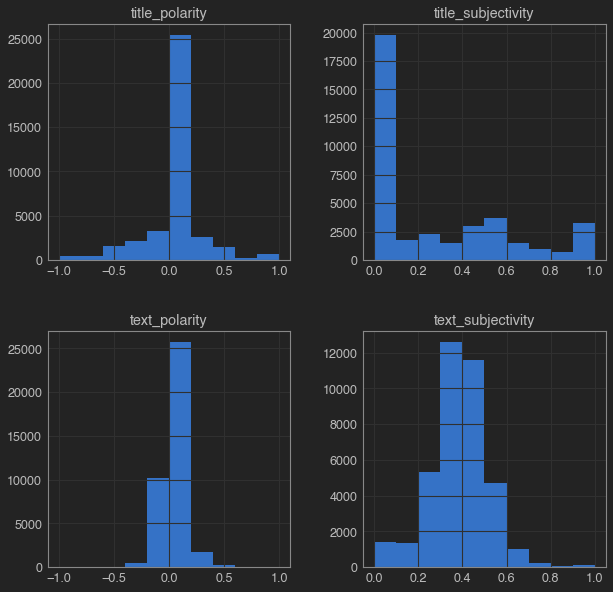

In [30]:
articles_df[['title_polarity','title_subjectivity','text_polarity','text_subjectivity']].hist(figsize=[10,10])

In [36]:
articles_df.is_fake.value_counts()

False    20734
True     17736
Name: is_fake, dtype: int64

In [34]:
articles_df.describe()

,title_polarity,title_subjectivity,text_polarity,text_subjectivity
count,38470.000000,38470.000000,38470.000000,38470.000000
mean,0.010495,0.261525,0.044279,0.384667
std,0.260526,0.325991,0.107559,0.134728
min,-1.000000,0.000000,-1.000000,0.000000
25%,0.000000,0.000000,-0.008235,0.315711
50%,0.000000,0.050000,0.041076,0.389255
75%,0.012500,0.500000,0.096591,0.462436
max,1.000000,1.000000,1.000000,1.000000


In [37]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38470 entries, 0 to 38469
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                38470 non-null  datetime64[ns]
 1   subject             38470 non-null  object        
 2   title               38470 non-null  object        
 3   text                38470 non-null  object        
 4   clean_title         38470 non-null  object        
 5   clean_text          38470 non-null  object        
 6   is_fake             38470 non-null  bool          
 7   title_polarity      38470 non-null  float64       
 8   title_subjectivity  38470 non-null  float64       
 9   text_polarity       38470 non-null  float64       
 10  text_subjectivity   38470 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(4), object(5)
memory usage: 3.0+ MB


### distribution takeaways
- titles overall don't seem to be polarized or subjective
- text polarity and subjectivity look normally distributed. Can perform T-tests
- fake articles are 46% of the dataset

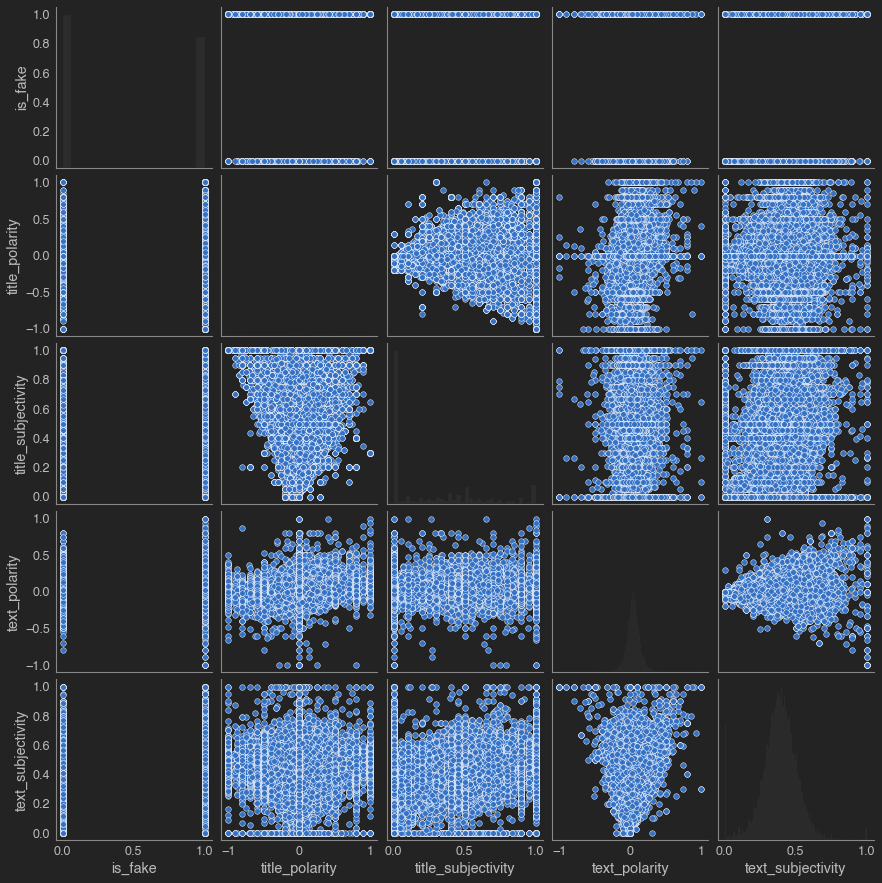

In [35]:
sns.pairplot(articles_df)

<AxesSubplot:xlabel='text_polarity', ylabel='text_subjectivity'>

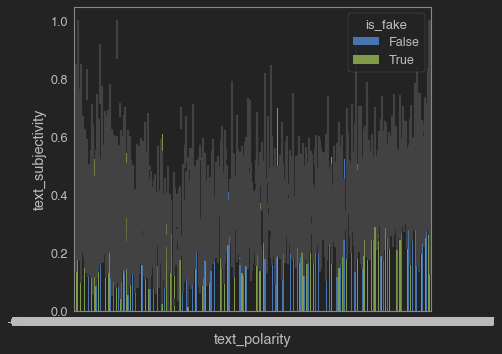

In [39]:
sns.barplot(x='text_polarity', y='text_subjectivity', data=articles_df, hue='is_fake')

<AxesSubplot:xlabel='title_polarity', ylabel='title_subjectivity'>

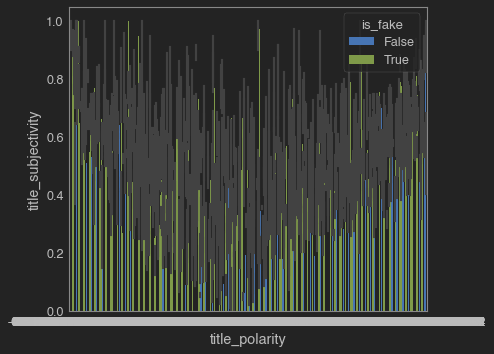

In [40]:
sns.barplot(x='title_polarity', y='title_subjectivity', data=articles_df, hue='is_fake')

<AxesSubplot:xlabel='is_fake', ylabel='text_polarity'>

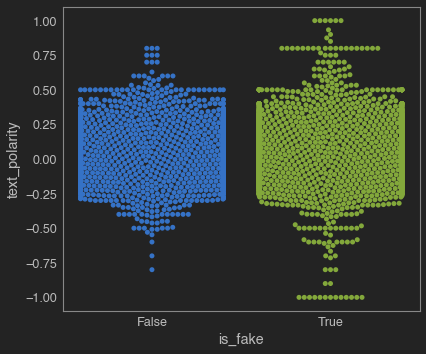

In [43]:
sns.swarmplot(x='is_fake', y='text_polarity',data=articles_df)

<AxesSubplot:xlabel='is_fake', ylabel='text_subjectivity'>

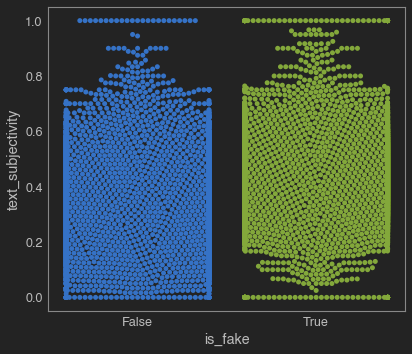

In [44]:
sns.swarmplot(x='is_fake', y='text_subjectivity',data=articles_df)

# 1. Is the mean text polarity of fake news articles more negative than real news?

In [88]:
articles_df = articles_df.dropna()

In [89]:
null_hypothesis = "The mean text polarity of fake news is the not more negative than real news"
alternative_hypothesis = "The mean text polarity of fake news is more negative than real news"
confidence_level = .95
a = 1 - confidence_level

In [90]:
real_news = articles_df[articles_df.is_fake == False]
fake_news = articles_df[articles_df.is_fake == True]

In [91]:
from scipy import stats
t, p = stats.ttest_ind(fake_news.text_polarity, real_news.text_polarity)
t, p

(2.0701553324486954, 0.03844445776679517)

In [92]:
# p/2 along with t < 0 is how we compare means if lowwer
if (p/2) < a and t < 0:
    print("Reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We fail to reject the null hypothesis


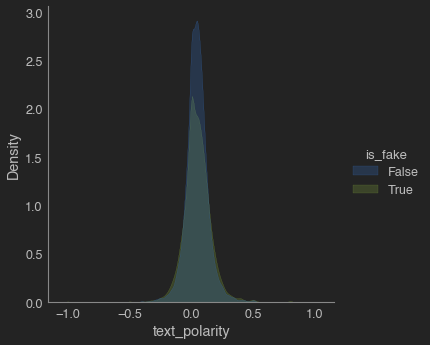

In [93]:
sns.displot(articles_df, x="text_polarity", hue="is_fake", kind="kde", fill=True)

In [94]:
fake_news.text_polarity.mean(), real_news.text_polarity.mean()

(0.04550611626308616, 0.04322879289995478)

### no significant difference between mean polarities

# 2. Is the mean text subjectivity of fake news articles greater than real news?

In [95]:
null_hypothesis = "The mean text subjectivity of fake news is the not more subjective than real news"
alternative_hypothesis = "The mean text subjectivity of fake news is more subjective than real news"
confidence_level = .95
a = 1 - confidence_level

In [96]:
t, p = stats.ttest_ind(fake_news.text_subjectivity, real_news.text_subjectivity)
t, p

(60.616137148732484, 0.0)

In [97]:
# p/2 along with t > 0 is how we compare means if higher
if (p/2) < a and t > 0:
    print("Reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Reject the null hypothesis


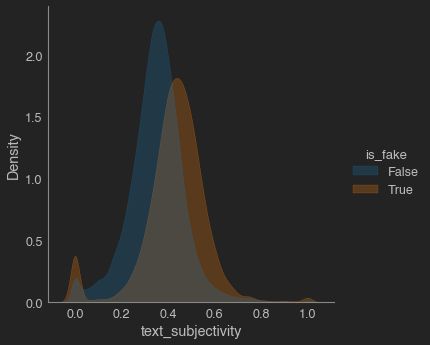

In [98]:
sns.displot(articles_df, x="text_subjectivity", hue="is_fake", kind="kde", fill=True, palette='tab10')

In [99]:
fake_news.text_subjectivity.mean(), real_news.text_subjectivity.mean()

(0.4276794647878942, 0.34787374010516636)

### fake_news 22% higher mean subjectivity score

In [73]:
test = pd.read_csv('articles.csv', index_col=0)

In [74]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38470 entries, 0 to 38469
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                38470 non-null  object 
 1   subject             38470 non-null  object 
 2   title               38470 non-null  object 
 3   text                38470 non-null  object 
 4   clean_title         38470 non-null  object 
 5   clean_text          38022 non-null  object 
 6   is_fake             38470 non-null  bool   
 7   title_polarity      38470 non-null  float64
 8   title_subjectivity  38470 non-null  float64
 9   text_polarity       38470 non-null  float64
 10  text_subjectivity   38470 non-null  float64
dtypes: bool(1), float64(4), object(6)
memory usage: 3.3+ MB


In [104]:
#over 51% of articles contain word trump
articles_df[articles_df.clean_text.str.contains('trump')].shape[0] / articles_df.shape[0]

0.5085781128151806

In [106]:
#of all articles contraining the word trump 52% are considered fake news
trump = articles_df[articles_df.clean_text.str.contains('trump')]
trump.is_fake.value_counts(normalize=True)

True     0.516841
False    0.483159
Name: is_fake, dtype: float64

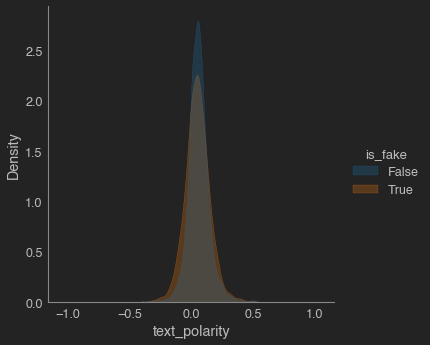

In [107]:
sns.displot(trump, x="text_polarity", hue="is_fake", kind="kde", fill=True, palette='tab10')

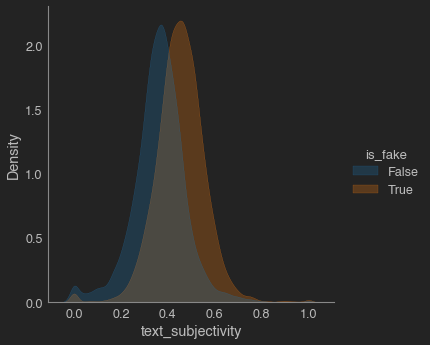

In [108]:
sns.displot(trump, x="text_subjectivity", hue="is_fake", kind="kde", fill=True, palette='tab10')

In [111]:
trump[trump.is_fake == True].text_polarity.mean(), trump[trump.is_fake == False].text_polarity.mean()

(0.047228572315460064, 0.05618795205624609)

In [112]:
trump[trump.is_fake == True].text_subjectivity.mean(), trump[trump.is_fake == False].text_subjectivity.mean()

(0.45179269032389263, 0.36219279634713986)

In [121]:
from spacy import displacy

text = trump.clean_text.iloc[0]

doc = nlp(text)
displacy.serve(doc, style="ent")


Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [123]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

muslim 146 152 NORP
one 273 276 CARDINAL
american 287 295 NORP
american 497 505 NORP
tuesday 552 559 DATE
nearly 300 560 570 CARDINAL
muslim 645 651 NORP
american 658 666 NORP
muslim 871 877 NORP
four 1230 1234 CARDINAL
iraqi 1257 1262 NORP
two 1279 1282 CARDINAL
five 1295 1299 CARDINAL
two 1318 1321 CARDINAL
one 1357 1360 CARDINAL
iraqi 1502 1507 NORP
friday 1783 1789 DATE
tuesday 2020 2027 DATE
tuesday 2289 2296 DATE
american 3187 3195 NORP
late night 3230 3240 TIME
300 3318 3321 CARDINAL
late night 3409 3419 TIME
late night 3523 3533 TIME


In [124]:
trump_fake_news = trump[trump.is_fake == True]

In [125]:
trump_fake_words = ' '.join(trump_fake_news.clean_text)

In [127]:
trump_fake_freq = pd.Series(trump_fake_words.split()).value_counts()
trump_fake_freq.head(20)

trump         62524
president     14718
donald        14509
said          13844
people        12490
would         11357
one           11081
republican    10165
image          9846
like           9497
u              8914
time           8368
state          8362
clinton        8339
say            7589
american       7528
even           7421
obama          7368
campaign       7031
white          7011
dtype: int64

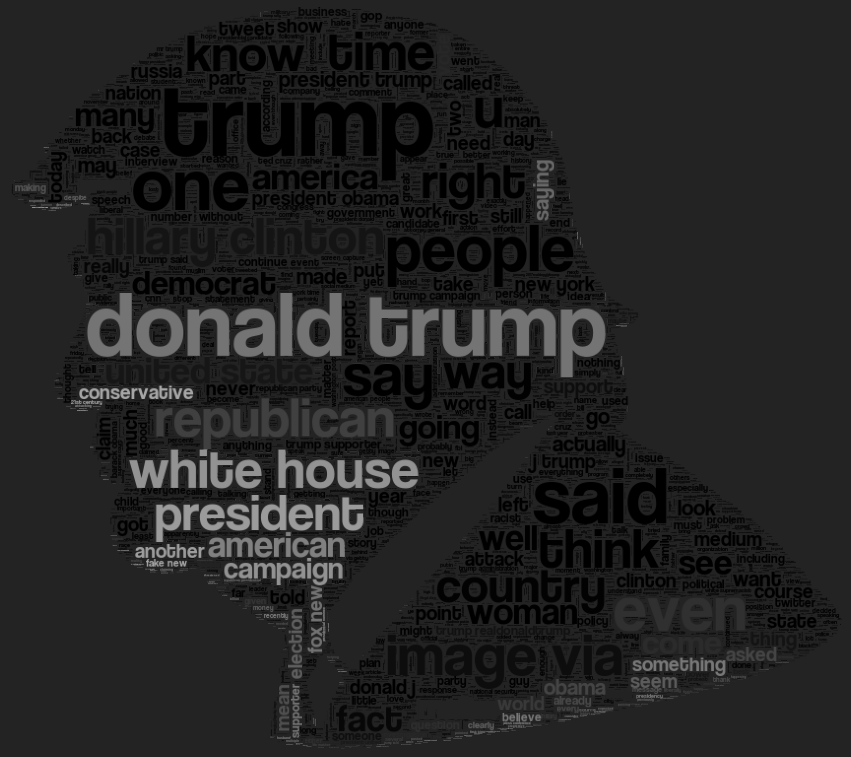

In [154]:
#masked python word cloud
font_path = 'Photos/coolvetica rg.ttf'
mask = np.array(Image.open('Photos/trump2.png'))
mask_colors = ImageColorGenerator(mask)
trump_fake_cloud = WordCloud(mask=mask,
                         width=mask.shape[1],
                         height=mask.shape[0],
                         max_words=None,
                         min_font_size=1,
                         font_path=font_path,
                         background_color=None,
                         mode='RGBA',
                         color_func=mask_colors,
                         random_state=45                         
                         #colormap='Blues',
                         ).generate(trump_fake_words)
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(trump_fake_cloud)

In [155]:
trump_fake_cloud.to_file('Photos/trump_fake_cloud.png')

In [146]:
articles_df.title_polarity.mean(), articles_df.title_subjectivity.mean()

(0.010495343575038627, 0.26152548428974726)

In [147]:
articles_df[articles_df.is_fake == True].title_polarity.mean(), articles_df[articles_df.is_fake == True].title_subjectivity.mean()

(-0.0031151060962813907, 0.3653035025217292)

In [156]:
trump.sample(50)

,date,subject,title,text,clean_title,clean_text,is_fake,title_polarity,title_subjectivity,text_polarity,text_subjectivity
23908,2017-07-18,politicsNews,"Trump, after Senate bill collapses, vows 'grea...",WASHINGTON (Reuters) - After Republicans’ effo...,trump senate bill collapse vow ' great healthc...,washington republican effort pas healthcare bi...,False,0.800000,0.750000,0.163095,0.596429
21202,2017-05-02,left-news,HILLARY GIVES HILARIOUS Reason For Losing Elec...,The Media Research Center recently published a...,hillary give hilarious reason losing election ...,medium research center recently published stud...,True,0.500000,0.875000,0.070578,0.504252
16103,2017-01-09,politicsNews,"Schumer urges delay in confirmation hearings, ...",WASHINGTON (Reuters) - Senate Democratic leade...,schumer urge delay confirmation hearing say re...,washington senate democratic leader chuck schu...,False,0.000000,0.000000,0.266667,0.600000
37201,2017-12-14,politicsNews,Fund managers seek stocks benefiting from Demo...,NEW YORK (Reuters) - The surprise victory by D...,fund manager seek stock benefiting democratic ...,new york surprise victory democrat tuesday ala...,False,0.000000,0.000000,0.051920,0.265763
1847,2016-01-07,politics,Former NYPD VIP Security Detail Says Hillary’s...,Almost as scary as the idea that Hillary would...,former nypd vip security detail say hillary de...,almost scary idea hillary would lie major heal...,True,-0.097222,0.180556,0.032666,0.421470
12116,2016-09-29,News,Trump Will HATE This Mexican Magazine For Unm...,"Mexico does not like Donald Trump, and for goo...",trump hate mexican magazine unmasking cover image,mexico like donald trump good reason accused p...,True,-0.400000,0.450000,0.041319,0.454861
23302,2017-06-28,News,"Trump Crumbles In GOP Health Care Meeting, Do...","Yesterday, after Senate Majority Leader Sen. M...",trump crumbles gop health care meeting doesnt ...,yesterday senate majority leader sen mitch mcc...,True,0.000000,0.000000,0.007788,0.461468
15600,2016-12-22,left-news,LEFTIST BULLY ARTISTS Tell Ivanka Trump: “Get ...,A growing group of artists is hitting back aga...,leftist bully artist tell ivanka trump get art...,growing group artist hitting back ivanka trump...,True,-0.050000,0.600000,0.003319,0.180772
2312,2016-01-20,News,These 10 Seconds Of Sarah Palin’s INSANE Trum...,Pretty much all of Sarah Palin s endorsement o...,10 second sarah palins insane trump endorsemen...,pretty much sarah palin endorsement republican...,True,-0.150000,0.725000,0.162434,0.590726
23190,2017-06-24,News,Trump F*cks Himself By Admitting Russia Inter...,"For months, Donald Trump has denied that Russi...",trump fcks admitting russia interfered 2016 el...,month donald trump denied russia meddled 2016 ...,True,0.800000,0.400000,-0.110038,0.421679


In [157]:
import re
def count_twitters_user(df):
    twitter_username_re = re.compile(r'@([A-Za-z0-9_]+)')
    count = 0
    list_ = []
    for text in df['text']:
        count += len(re.findall(twitter_username_re, text))
    return count

In [160]:
count_twitters_user(articles_df[articles_df.is_fake == True]) , count_twitters_user(articles_df[articles_df.is_fake == False])

(23525, 789)

In [161]:
fake = articles_df[articles_df.is_fake == True]
true = articles_df[articles_df.is_fake == False]

In [174]:
import plotly.express as px
import plotly.graph_objects as go

twitter_users_fake_count = count_twitters_user(fake)
twitter_users_true_count = count_twitters_user(true)
fig = go.Figure()
fig.add_trace(go.Bar(x=['Fake', 'True'],
    y=[twitter_users_fake_count, twitter_users_true_count],
    name='Twitter user name Pattern',
    marker_color='cadetblue')
)
fig.update_layout({
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        'title': 'unique hashtags mentions in twitter',
})

fig.update_layout(
    autosize=False,
    width=800,
    height=800)
#fig = px.bar(y=[twitter_users_fake_count, twitter_users_true_count], x=['Fake', 'True'], title='Twitter user name Pattern')

fig.show()